# Project Upgrade Success/Failure Analysis

Simple analysis showing the proportion of successful vs failed upgrades by project.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

## Load Data and Create Plot

In [3]:
# Load the CSV file
df = pd.read_csv('data/metadata_upgrade_status_20251007_145733.csv')
df.head()

,v1_id,v2_id,upgrader_version,last_modified,status,_id,name,data_level,project_name
0,000099c0-eab2-4d83-bcdc-440954c1e60d,a82c2998-6e26-47de-baea-b12c425ba30f,0.0.29,2025-09-11T17:40:38.332Z,success,000099c0-eab2-4d83-bcdc-440954c1e60d,behavior_775510_2025-04-13_15-30-30_processed_...,derived,AIND Viral Genetic Tools
1,00051a6d-a9d6-43a4-aac2-9b6b28fff564,b8621ddf-fa97-4d4d-9d74-1198dc7b63b2,0.0.29,2025-09-11T17:42:08.659Z,success,00051a6d-a9d6-43a4-aac2-9b6b28fff564,behavior_757128_2024-09-27_09-13-43_processed_...,derived,NaN
2,0006700f-3481-4a80-ab41-0ac904f7f92f,NaN,0.0.29,2025-09-30T03:16:57.497Z,failed,0006700f-3481-4a80-ab41-0ac904f7f92f,behavior_775743_2025-03-05_09-24-15_processed_...,derived,Behavior Platform
3,0007a18c-e1c3-426d-af54-8d5a1aeab018,48819b80-b35e-4577-99c6-08bbe8163206,0.0.29,2025-09-11T17:41:13.173Z,success,0007a18c-e1c3-426d-af54-8d5a1aeab018,behavior_770803_2025-02-13_13-04-57,raw,Behavior Platform
4,0008d481-1376-4be9-92d0-c61d1785c7ad,NaN,0.0.29,2025-02-18T18:26:16.982Z,failed,0008d481-1376-4be9-92d0-c61d1785c7ad,HCR_732195-ROI2-cell15_2024-06-15_06-00-00,raw,NaN


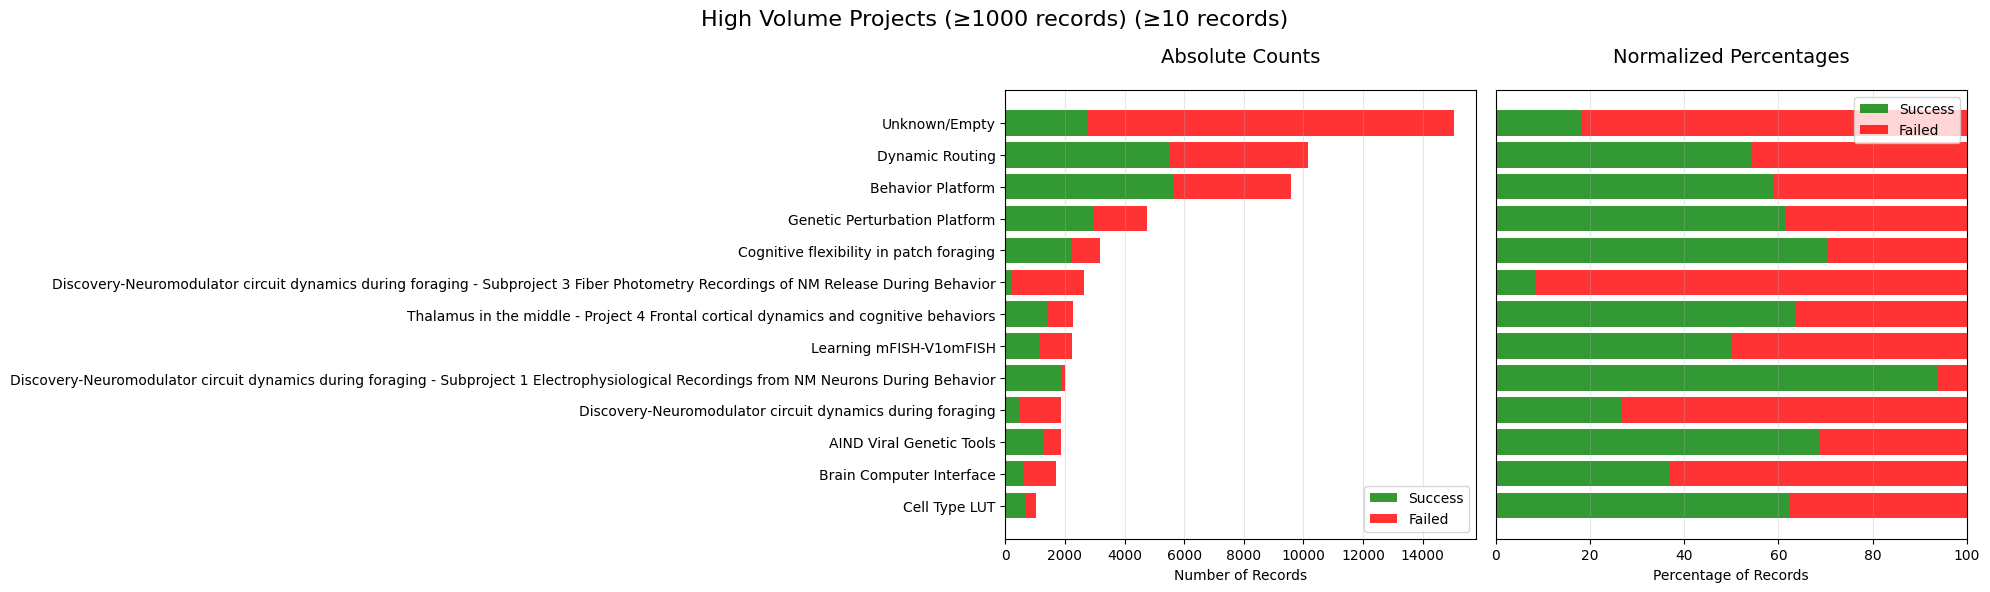

High Volume Projects (≥1000 records): 13 projects


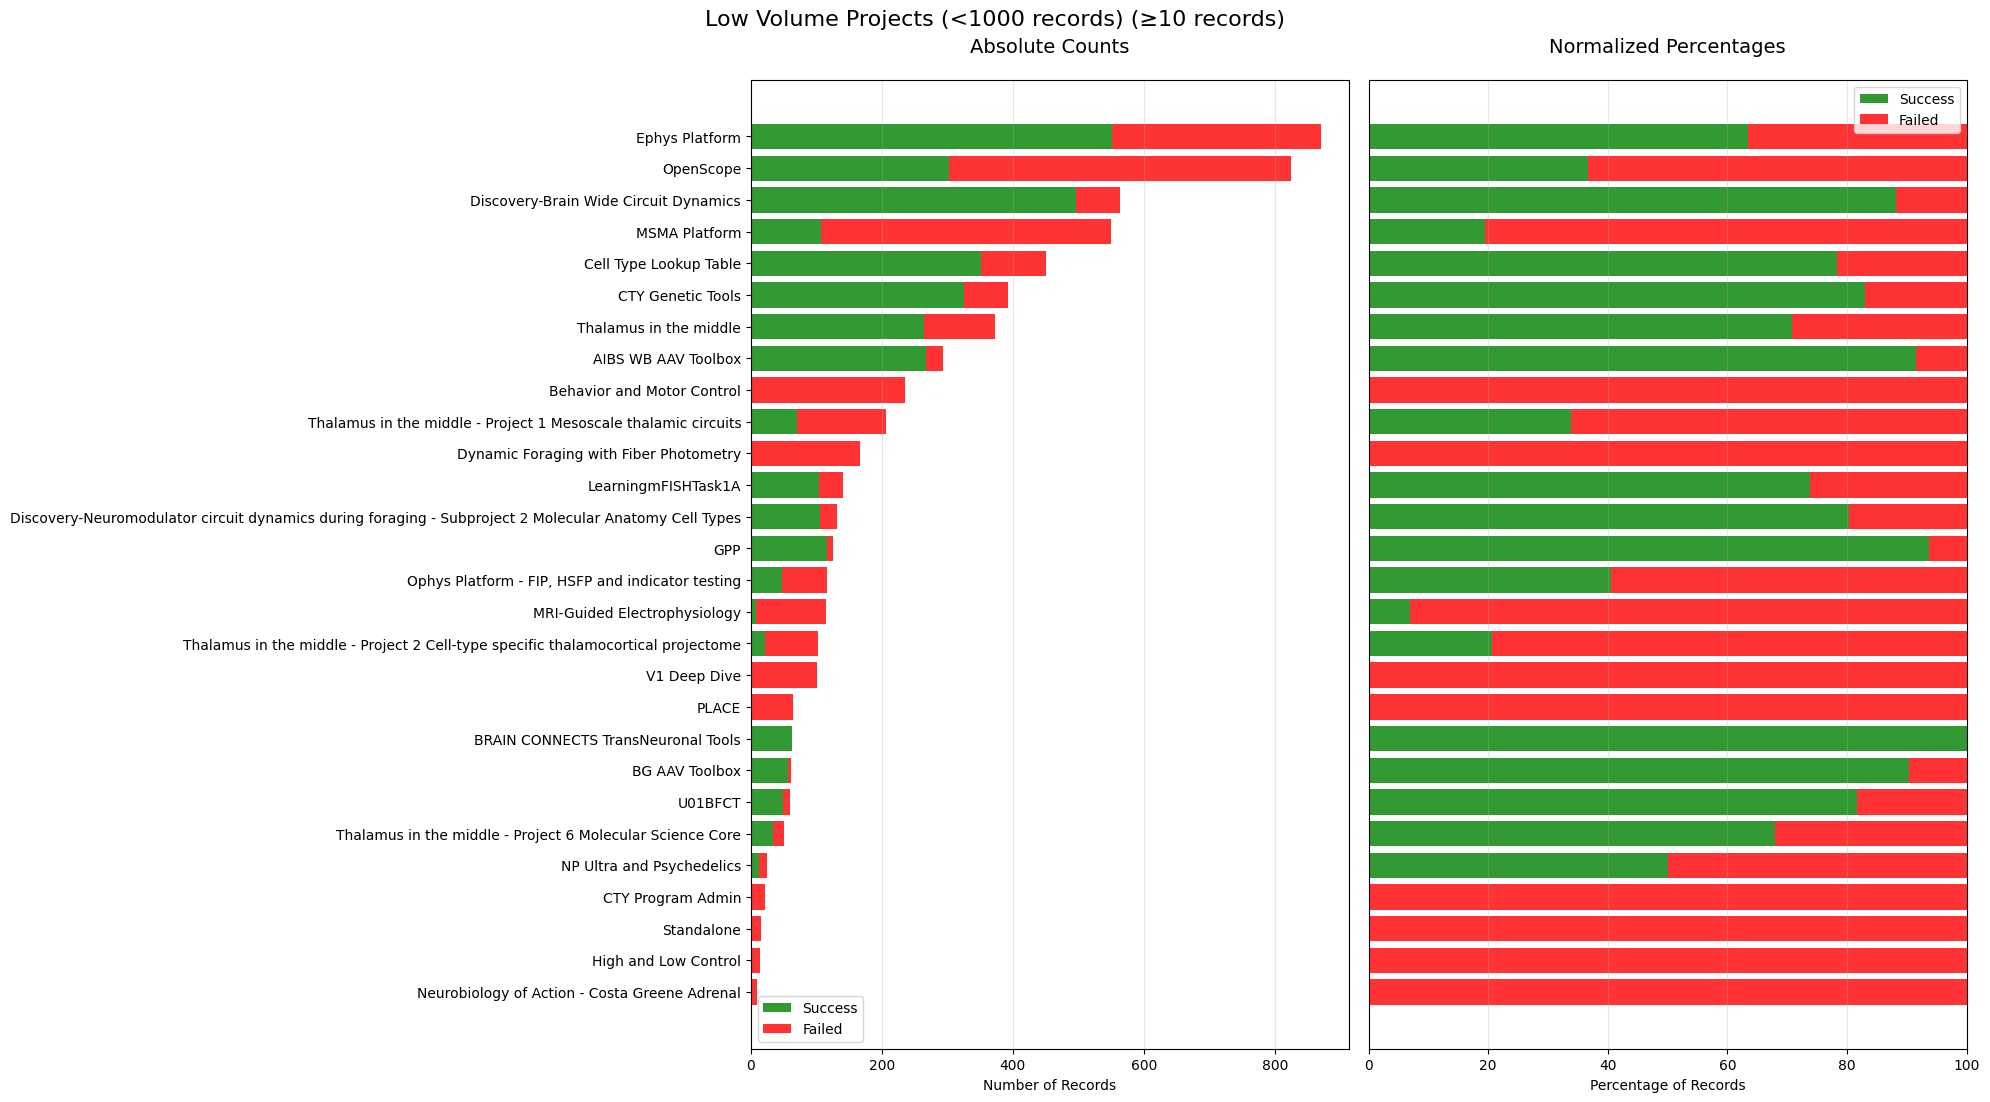

Low Volume Projects (<1000 records): 28 projects

Total projects analyzed: 41
High volume (≥1000 records): 13
Low volume (<1000 records): 28


In [ ]:

# Handle missing project names
df['project_name'] = df['project_name'].fillna('Unknown/Empty')

# Count successes and failures by project
project_counts = df.groupby(['project_name', 'status']).size().unstack(fill_value=0)

# Only include projects with at least 10 records to avoid noise
project_totals = project_counts.sum(axis=1)
projects_with_enough_data = project_totals[project_totals >= 10].index
filtered_counts = project_counts.loc[projects_with_enough_data]

# Add total column
filtered_counts['total'] = filtered_counts.sum(axis=1)

# Split into high-volume (≥1000) and low-volume (<1000) projects
high_volume = filtered_counts[filtered_counts['total'] >= 1000].sort_values('total', ascending=True)
low_volume = filtered_counts[filtered_counts['total'] < 1000].sort_values('total', ascending=True)

# Function to create a plot
def create_plot(data, title, ax):
    if len(data) == 0:
        ax.text(0.5, 0.5, 'No projects in this category', ha='center', va='center', transform=ax.transAxes)
        ax.set_title(title, fontsize=14, pad=20)
        return
    
    success_counts = data.get('success', 0)
    failed_counts = data.get('failed', 0)
    success_pct = (success_counts / data['total'] * 100)
    failed_pct = (failed_counts / data['total'] * 100)
    
    # Create side-by-side plots for this category
    fig_sub, (ax_abs, ax_pct) = plt.subplots(1, 2, figsize=(20, max(6, len(data) * 0.4)))
    
    # Absolute counts
    ax_abs.barh(range(len(data)), success_counts, label='Success', color='green', alpha=0.8)
    ax_abs.barh(range(len(data)), failed_counts, left=success_counts, label='Failed', color='red', alpha=0.8)
    
    ax_abs.set_yticks(range(len(data)))
    ax_abs.set_yticklabels(data.index, fontsize=10)
    ax_abs.set_xlabel('Number of Records')
    ax_abs.set_title('Absolute Counts', fontsize=14, pad=20)
    ax_abs.legend()
    ax_abs.grid(axis='x', alpha=0.3)
    
    # Percentages
    ax_pct.barh(range(len(data)), success_pct, label='Success', color='green', alpha=0.8)
    ax_pct.barh(range(len(data)), failed_pct, left=success_pct, label='Failed', color='red', alpha=0.8)
    
    ax_pct.set_yticks([])
    ax_pct.set_yticklabels([])
    ax_pct.set_xlabel('Percentage of Records')
    ax_pct.set_title('Normalized Percentages', fontsize=14, pad=20)
    ax_pct.legend()
    ax_pct.grid(axis='x', alpha=0.3)
    ax_pct.set_xlim(0, 100)
    
    plt.suptitle(f'{title} (≥10 records)', fontsize=16, y=0.98)
    plt.tight_layout()
    plt.show()
    
    print(f"{title}: {len(data)} projects")

# Create plots for each category
create_plot(high_volume, 'High Volume Projects (≥1000 records)', None)
create_plot(low_volume, 'Low Volume Projects (<1000 records)', None)

print(f"\nTotal projects analyzed: {len(filtered_counts)}")
print(f"High volume (≥1000 records): {len(high_volume)}")
print(f"Low volume (<1000 records): {len(low_volume)}")

## Find Failed Assets by Project

Enter a project name to see all asset names that failed to upgrade for that project.

In [28]:
# Function to find failed assets for a specific project
def find_failed_assets(project_name):
    """
    Find all asset names that failed to upgrade for a given project.
    
    Args:
        project_name (str): Name of the project to search for
    
    Returns:
        List of asset names that failed to upgrade
    """
    # Handle missing project names in the search
    df_search = df.copy()
    df_search['project_name'] = df_search['project_name'].fillna('Unknown/Empty')
    
    # Filter for the specific project and failed status
    failed_assets = df_search[
        (df_search['project_name'] == project_name) & 
        (df_search['status'] == 'failed')
    ]
    
    if len(failed_assets) == 0:
        print(f"No failed assets found for project: '{project_name}'")
        
        # Check if the project exists at all
        project_exists = df_search[df_search['project_name'] == project_name]
        if len(project_exists) == 0:
            print(f"Project '{project_name}' not found in the dataset.")
            print("Available projects:")
            unique_projects = sorted(df_search['project_name'].unique())
            for proj in unique_projects[:20]:  # Show first 20
                print(f"  - {proj}")
            if len(unique_projects) > 20:
                print(f"  ... and {len(unique_projects) - 20} more projects")
        else:
            success_count = len(project_exists[project_exists['status'] == 'success'])
            print(f"Great! All {success_count} assets in this project upgraded successfully.")
    else:
        total_assets = len(df_search[df_search['project_name'] == project_name])
        success_count = total_assets - len(failed_assets)
        
        print(f"Project: '{project_name}'")
        print(f"Total assets: {total_assets}")
        print(f"Successful upgrades: {success_count}")
        print(f"Failed upgrades: {len(failed_assets)}")
        print(f"\nFailed asset names:")
        print("-" * 50)
        
        for idx, asset_name in enumerate(failed_assets['name'].values, 1):
            print(f"{idx:3d}. {asset_name}")
    
    return failed_assets['name'].tolist()

# Example usage - change the project name below
project_to_search = "Cognitive flexibility in patch foraging"
failed_asset_names = find_failed_assets(project_to_search)

Project: 'Cognitive flexibility in patch foraging'
Total assets: 3193
Successful upgrades: 2248
Failed upgrades: 945

Failed asset names:
--------------------------------------------------
  1. behavior_754575_2024-10-15_13-11-07
  2. behavior_745302_2024-11-30_11-51-25
  3. behavior_745302_2024-10-11_11-25-20
  4. behavior_754573_2024-09-04_20-58-43
  5. behavior_789919_2025-06-17_19-56-49_processed_2025-09-23_18-50-44
  6. behavior_789926_2025-06-24_18-14-39_videoprocessed_2025-09-29_02-57-03
  7. behavior_754575_2024-09-05_13-11-26
  8. behavior_789925_2025-04-18_18-19-24
  9. behavior_789908_2025-04-16_18-34-55
 10. behavior_754575_2024-10-20_13-38-17
 11. behavior_754574_2025-06-25_17-01-03
 12. behavior_754575_2024-10-02_13-05-37
 13. behavior_754567_2024-09-20_13-40-49
 14. behavior_754571_2024-10-10_11-02-42
 15. behavior_745305_2024-11-05_10-58-07
 16. behavior_788641_2025-09-17_21-10-54_processed_2025-09-24_20-14-09
 17. behavior_789926_2025-04-02_17-58-10
 18. behavior_74530

## Summary Table of All Projects

Complete list of all projects with their success/failure counts for easy reference.

In [29]:
# Create summary table of all projects
df_summary = df.copy()
df_summary['project_name'] = df_summary['project_name'].fillna('Unknown/Empty')

# Group by project and status to get counts
project_summary = df_summary.groupby(['project_name', 'status']).size().unstack(fill_value=0)

# Add total and success rate columns
project_summary['total'] = project_summary.sum(axis=1)
project_summary['success_rate'] = (project_summary.get('success', 0) / project_summary['total'] * 100).round(1)

# Sort by total count (descending) for easy reference
project_summary = project_summary.sort_values('total', ascending=False)

# Print formatted table
print("=" * 100)
print("PROJECT SUMMARY TABLE")
print("=" * 100)
print(f"{'Project Name':<50} {'Total':<8} {'Success':<8} {'Failed':<8} {'Success %':<10}")
print("-" * 100)

for project, row in project_summary.iterrows():
    project_display = project[:48] + ".." if len(project) > 50 else project
    success_count = int(row.get('success', 0))
    failed_count = int(row.get('failed', 0))
    total_count = int(row['total'])
    success_rate = row['success_rate']
    
    print(f"{project_display:<50} {total_count:<8} {success_count:<8} {failed_count:<8} {success_rate:<10.1f}")

print("-" * 100)
print(f"Total projects: {len(project_summary)}")
print(f"Total assets: {project_summary['total'].sum():,}")
print(f"Overall success rate: {(project_summary.get('success', 0).sum() / project_summary['total'].sum() * 100):.1f}%")

# Save to a variable for easy access
all_projects_summary = project_summary
print(f"\nSummary saved to variable 'all_projects_summary' for programmatic access.")

PROJECT SUMMARY TABLE
Project Name                                       Total    Success  Failed   Success % 
----------------------------------------------------------------------------------------------------
Unknown/Empty                                      15054    2738     12316    18.2      
Dynamic Routing                                    10155    5514     4641     54.3      
Behavior Platform                                  9569     5635     3934     58.9      
Genetic Perturbation Platform                      4754     2927     1827     61.6      
Cognitive flexibility in patch foraging            3193     2248     945      70.4      
Discovery-Neuromodulator circuit dynamics during.. 2647     227      2420     8.6       
Thalamus in the middle - Project 4 Frontal corti.. 2269     1441     828      63.5      
Learning mFISH-V1omFISH                            2249     1130     1119     50.2      
Discovery-Neuromodulator circuit dynamics during.. 2003     1876     127    

In [5]:
# Create summary table of all projects
df_summary = df.copy()
df_summary = df_summary[df_summary['data_level'] == 'raw'] 
df_summary['project_name'] = df_summary['project_name'].fillna('Unknown/Empty')

# Group by project and status to get counts
project_summary = df_summary.groupby(['project_name', 'status']).size().unstack(fill_value=0)

# Add total and success rate columns
project_summary['total'] = project_summary.sum(axis=1)
project_summary['success_rate'] = (project_summary.get('success', 0) / project_summary['total'] * 100).round(1)

# Sort by total count (descending) for easy reference
project_summary = project_summary.sort_values('total', ascending=False)

# Print formatted table
print("=" * 100)
print("PROJECT SUMMARY TABLE")
print("=" * 100)
print(f"{'Project Name':<50} {'Total':<8} {'Success':<8} {'Failed':<8} {'Success %':<10}")
print("-" * 100)

for project, row in project_summary.iterrows():
    project_display = project[:48] + ".." if len(project) > 50 else project
    success_count = int(row.get('success', 0))
    failed_count = int(row.get('failed', 0))
    total_count = int(row['total'])
    success_rate = row['success_rate']
    
    print(f"{project_display:<50} {total_count:<8} {success_count:<8} {failed_count:<8} {success_rate:<10.1f}")

print("-" * 100)
print(f"Total projects: {len(project_summary)}")
print(f"Total assets: {project_summary['total'].sum():,}")
print(f"Overall success rate: {(project_summary.get('success', 0).sum() / project_summary['total'].sum() * 100):.1f}%")

# Save to a variable for easy access
all_projects_summary = project_summary
print(f"\nSummary saved to variable 'all_projects_summary' for programmatic access.")

PROJECT SUMMARY TABLE
Project Name                                       Total    Success  Failed   Success % 
----------------------------------------------------------------------------------------------------
Dynamic Routing                                    8801     5210     3591     59.2      
Behavior Platform                                  5196     3256     1940     62.7      
Unknown/Empty                                      3332     505      2827     15.2      
Cognitive flexibility in patch foraging            3172     2248     924      70.9      
Genetic Perturbation Platform                      2442     1509     933      61.8      
Brain Computer Interface                           1471     570      901      38.7      
Discovery-Neuromodulator circuit dynamics during.. 1339     327      1012     24.4      
Discovery-Neuromodulator circuit dynamics during.. 1309     129      1180     9.9       
Thalamus in the middle - Project 4 Frontal corti.. 1184     753      431    